In [27]:
!pip install turicreate nltk gensim scikit-learn textblob matplotlib seaborn wordcloud missingno numpy~=1.21.6 xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 MB 13.4 MB/s eta 0:00:0000:0100:01


In [1]:
from __future__ import annotations

import os
import warnings

import pandas as pd

warnings.filterwarnings('ignore')

# Data Preprocessing & NLP
import nltk
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer

from utils import *

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/azalea/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/azalea/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 0. Preprocessing

## 0.1. Preprocess Fucntions

In [7]:
import unicodedata
import nltk
import string
from nltk.corpus import stopwords


STOPWORDS = stopwords.words('english')
TOK = nltk.tokenize.toktok.ToktokTokenizer()
PORTER_STEMMER = nltk.porter.PorterStemmer()
WHITELIST = string.digits + string.whitespace + string.ascii_letters


def remove_punctuation(text: str) -> str:
    # Replace accented chars with normal form
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore').strip()

    # Remove double space
    while '  ' in text:
        text = text.replace('  ', ' ')

    # Keep only A-Z, a-z, 0-9, space
    return ''.join(c for c in text if c in WHITELIST)


def remove_stopwords(text: str) -> str:
    tokens = [t.strip() for t in TOK.tokenize(text.lower())]
    return ' '.join(t for t in tokens if t not in STOPWORDS)


def stem(text: str) -> str:
    return ' '.join([PORTER_STEMMER.stem(word) for word in text.split()])


def preprocess(text: str) -> str:
    return stem(remove_stopwords(remove_punctuation(text)))

In [8]:
dataset = pd.read_csv('dataset/reviews.csv', encoding='ISO-8859-1')

# Data Cleaning
dataset['reviewTextProc'] = dataset['reviewText'].apply(preprocess)

## 0.2 Wordcloud Visualization

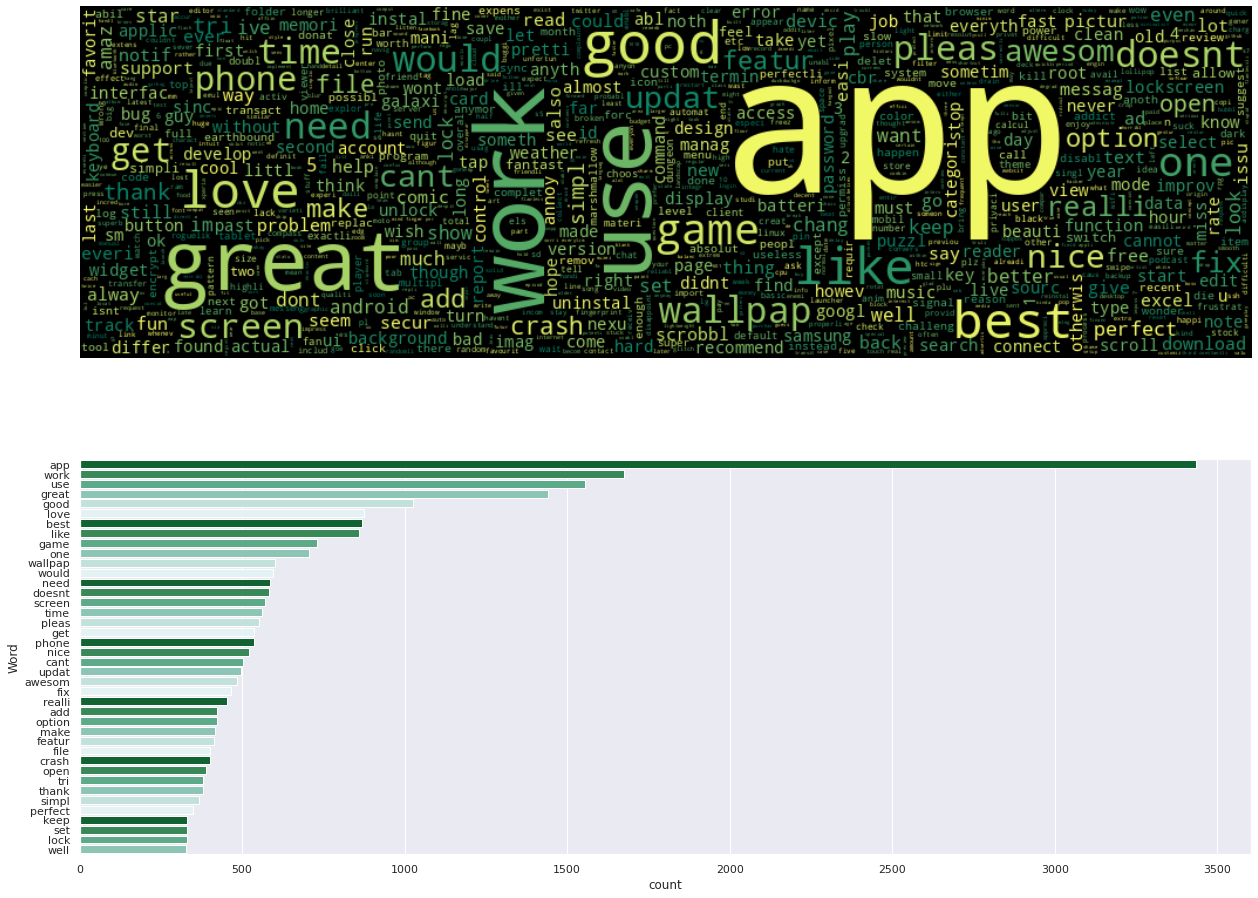

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


def word_cloud(x, terms = 40):
    all_words = ' '.join(x).split()

    freq_dist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word': list(freq_dist.keys()), 'count': list(freq_dist.values())})

    fig = plt.figure(figsize=(21,16))
    ax1 = fig.add_subplot(2,1,1)
    wordcloud = WordCloud(width=1000, height=300, background_color='black',
                          max_words=1628, relative_scaling=1, colormap='summer',
                          normalize_plurals=False).generate_from_frequencies(freq_dist)

    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')

    # select top 40 most frequent word
    ax2 = fig.add_subplot(2,1,2)
    d = words_df.nlargest(columns="count", n = terms)
    ax2 = sns.barplot(data=d, palette = sns.color_palette('BuGn_r'), x= "count", y = "word")
    ax2.set(ylabel= 'Word')
    plt.show()


word_cloud(dataset['reviewTextProc'])

# 1. RQ1: Classifying Reviews

To what extent does the User Request Referencer organize reviews according to meaningful maintenance and evolution tasks for developers?

### 1.1. Performance Evaluation & Plotting Functions

In [35]:
from typing import NamedTuple
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from matplotlib.axes import Axes
from matplotlib.figure import Figure


class Performance(NamedTuple):
    cat: str
    accuracy: float
    precision: float
    recall: float
    f1: float

    def print(self):
        print(f'Precision : {100 * self.precision:.1f}%')
        print(f'Recall : {100 * self.recall:.1f}%')
        print(f'F1-score : {100 * self.f1:.1f}%')


def get_performance(cat: str, y_true, y_pred) -> Performance:
    """
    Evaluate model prediction performance
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1score, support = score(y_true, y_pred, pos_label=1, average='binary')

    return Performance(cat, *[round(m * 100, 1) for m in [accuracy, precision, recall, f1score]])


def plot_classification_result(cls_res: pd.DataFrame, title: str):
    fig, ax = plt.subplots(ncols=2, figsize=(8, 6), sharey=True)
    fig: Figure
    ax: list[Axes]

    for a in ax:
        [a.spines[k].set_visible(False) for k in ['top', 'right', 'bottom', 'left']]

    args = dict(orient='v', color='#d0ffb4', inner="quartile")
    sns.violinplot(data=cls_res[['Prec', 'Recall', 'F1']], ax=ax[0], **args)
    # sns.violinplot(data=DF(np.log10(num_issues), columns=['Issue Reports']), ax=ax[1], **args)

    ax[0].set_ylabel('Ratio or Percentage')

    plot(title=title).show()

### 1.2. Prepare train/test datasets

In [36]:
from scipy import sparse
import random
from typing import NamedTuple


all_categories = ['APP USABILITY', 'UI', 'DEVICE', 'ANDROID VERSION', 'HARDWARE', 'PERFORMANCE', 'BATTERY', 'MEMORY', 'LICENSING', 'PRICE', 'PRIVACY', 'SECURITY', 'USAGE', 'COMPATIBILITY', 'RESSOURCES', 'PRICING', 'PROTECTION', 'ERROR']
# all_categories = ['APP USABILITY', 'UI', 'DEVICE', 'ANDROID VERSION', 'HARDWARE', 'PERFORMANCE', 'BATTERY', 'MEMORY', 'LICENSING', 'PRICE', 'PRIVACY', 'SECURITY']


class TrainTestSet(NamedTuple):
    x_train: np.ndarray
    y_train: np.ndarray
    x_test: np.ndarray
    y_test: np.ndarray


def prepare_train_test_set(cat: str) -> TrainTestSet:
    # test_set = pd.read_csv(f'dataset/RQ_1/low/{cat}_final.csv', encoding='ISO-8859-1')
    test_set = pd.read_csv(f'dataset/RQ_1_mod/{cat}_final.csv', encoding='UTF-8')

    # Clean test set
    test_set['reviewTextProc'] = test_set['reviewText'].apply(preprocess)

    # exclude those reviews from label_data2 that are in test dataset (by matching ids)
    df = dataset[~dataset._id.isin(test_set._id)]

    # Delete rows with empty subclasses from dataFrame
    indexNames = df[df['subclasses'] == '[]'].index
    df.drop(indexNames , inplace=True)

    # TF-IDF transform
    tfidf_vec = TfidfVectorizer(ngram_range=(1, 3), max_features=1000)

    x_train = tfidf_vec.fit_transform(df['reviewTextProc'].to_numpy())
    y_train = df[f'IS_{cat}'].to_numpy()

    x_test = tfidf_vec.transform(test_set['reviewTextProc'].to_numpy())
    y_test = test_set['Actual Label'].to_numpy()  # Actual Label = 'PREDICTED_{TAXONOMY}' xor 'CORRECT'

    # Resample: Use the same number of 1s and 0s (Since there are significantly more 0s than 1s)
    num_1s = sum(y_train)
    x_0s = x_train[y_train == 0]
    x_1s = x_train[y_train == 1]
    num_0s = min(num_1s, x_0s.shape[0])

    x_0s = x_0s[random.sample(range(x_0s.shape[0]), num_0s)]
    x_train = sparse.vstack([x_0s, x_1s])
    y_train = np.array([0] * num_0s + [1] * num_1s)
    assert len(y_train) == x_train.shape[0]

    return TrainTestSet(x_train.todense(), y_train, x_test.todense(), y_test)


train_test_sets = dict(zip(all_categories, pmap(prepare_train_test_set, all_categories)))

100%|██████████| 18/18 [00:01<00:00, 11.72it/s]


### 1.4. Classification using XGBoost

In [41]:
import xgboost


def classify_cat_xgboost(cat: str) -> Performance:
    x_train, y_train, x_test, y_test = train_test_sets[cat]

    # turicreate model
    model = xgboost.XGBClassifier(tree_method='gpu_hist', n_estimators=300)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    # Performance metrics
    return get_performance(cat, y_test, pd.Series(y_pred))

classification_result_xg = smap(classify_cat_xgboost, all_categories)
pd.DataFrame(classification_result_xg, columns=['Taxonomy', 'Acc', 'Prec', 'Recall', 'F1'])

100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


,Taxonomy,Acc,Prec,Recall,F1
0,APP USABILITY,85.0,85.9,84.2,85.0
1,UI,85.5,78.8,92.1,85.0
2,DEVICE,91.0,85.2,93.8,89.3
3,ANDROID VERSION,86.5,51.0,92.9,65.8
4,HARDWARE,83.5,53.2,89.2,66.7
5,PERFORMANCE,79.0,62.2,92.4,74.4
6,BATTERY,96.0,76.2,84.2,80.0
7,MEMORY,96.0,72.4,100.0,84.0
8,LICENSING,93.5,83.3,91.8,87.4
9,PRICE,92.0,78.2,91.5,84.3


### Choose Hyper-parameters for XGBoost

In [18]:
import xgboost


def classify_cat_xg_n(cat: str, n_estimators: int) -> Performance:
    x_train, y_train, x_test, y_test, train_df, test_df = train_test_sets[cat]

    # turicreate model
    model = xgboost.XGBClassifier(tree_method='gpu_hist', n_estimators=n_estimators, max_depth=3)
    model.fit(x_train, np.expand_dims(y_train.values, 1))

    y_pred = model.predict(x_test)

    # Performance metrics
    return get_performance(cat, y_test, pd.Series(y_pred))


def choose_n_f1(n_estimators: int) -> float:
    """
    Classify all categories with a specific n_estimators value and return the mean f1 score for all
    categories
    """
    result = [classify_cat_xg_n(cat, n_estimators) for cat in all_categories]
    df = pd.DataFrame(result, columns=['Taxonomy', 'Acc', 'Prec', 'Recall', 'F1'])
    mean_f1 = df['F1'].mean()
    return mean_f1

In [ ]:
# choose_n_f1(2)
hyper_n_x = list(range(2, 101, 5))
hyper_n_f1 = [choose_n_f1(n) for n in tq(hyper_n_x, 'Training')]

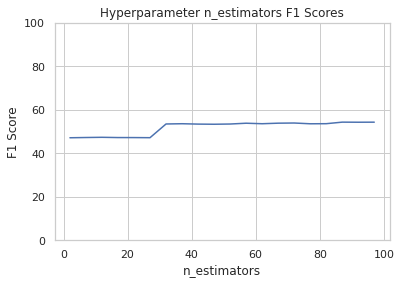

In [69]:
from pathlib import Path

plt.plot(hyper_n_x, hyper_n_f1)
plot(title='Hyperparameter n_estimators F1 Scores', ylabel='F1 Score', ylim=[0, 100], xlabel='n_estimators')
Path('fig').mkdir(exist_ok=True)
_ = plt.savefig('fig/hp_n_f1.png')
plt.show()

In [71]:
hyper_n_2 = choose_n_f1(2)
hyper_n_100 = choose_n_f1(100)
print(f'n=2   F1: {hyper_n_2:.1f}')
print(f'n=100 F1: {hyper_n_100:.1f}')
print(f'Percent increase: {(hyper_n_100 - hyper_n_2) / hyper_n_2 * 100:.1f}')

n=2   F1: 47.2
n=100 F1: 55.6
Percent increase: 17.9


In [19]:
train_test_sets = train_test_sets_1000
hyper_tfidf_1000 = choose_n_f1(100)
train_test_sets = train_test_sets_full
hyper_tfidf_full = choose_n_f1(100)
print(f'TF-IDF top 1000 F1: {hyper_tfidf_1000:.1f}')
print(f'TF-IDF top 5000 F1: {hyper_tfidf_full:.1f}')
print(f'Percent increase: {(hyper_tfidf_full - hyper_tfidf_1000) / hyper_tfidf_1000 * 100:.1f}')

TF-IDF top 1000 F1: 55.9
TF-IDF top 5000 F1: 55.6
Percent increase: -0.5


In [21]:
from multiprocessing import Pool


def _foo(x):
    time.sleep(1000)


with Pool(36) as p:
    p.map(_foo, range(1000))

In [25]:
import turicreate as tc


def classify_cat(cat: str):
    test_set = pd.read_csv(f'../{cat}_manual.csv', encoding='ISO-8859-1')
    # test_set = pd.read_csv(f'dataset/RQ_1/low/{cat}_final.csv', encoding='ISO-8859-1')
    test_set['soup'] = test_set['reviewText'].apply(clean_text)
    test_set['soup'] = test_set['soup'].apply(lambda x: remove_stopwords(x))

    # exclude those reviews from label_data2 that are in test dataset (by matching ids)
    df = dataset[~dataset._id.isin(test_set._id)]

    # Delete rows with empty subclasses from dataFrame
    indexNames = df[df['subclasses'] == '[]'].index
    df.drop(indexNames , inplace=True)

    # df = dataset.copy()

    # over sampling
    class_count_0, class_count_1 = df[cat].value_counts()
    class_0 = df[df[cat] == 0]
    class_1 = df[df[cat] == 1]
    class_1_over = class_1.sample(2 * class_count_0, replace=True)
    df = pd.concat([class_1_over, class_0], axis=0)

    # df = df.sample(n=math.floor(0.8 * len(dataset)), replace=False)

    X_train = df['soup']
    y_train = df[cat]
    df[['soup', cat]].to_csv('test.csv')
    xtrain_tfidf = tfidf_vec.fit_transform(X_train)

    # X_test = test_set['soup']
    # y_test = test_set['CORRECT']
    # #y_test = test_set['Manual by Azalea']
    # xtest_tfidf = tfidf_vec.transform(X_test)

    data = np.hstack((xtrain_tfidf.todense(), np.expand_dims(y_train.values, 1)))
    train_data_df = pd.DataFrame(data, columns=list(tfidf_vec.vocabulary_.keys()) + ['target'])
    train_data_df['target'] = train_data_df['target'].astype(int)


    # turicreate model
    print(f'Training for {cat}...')
    model = tc.boosted_trees_classifier.create(tc.SFrame(data=train_data_df), target='target', max_iterations=2, max_depth=3, verbose=False)

    data = xtrain_tfidf.todense()
    test_data_df = pd.DataFrame(data, columns=list(tfidf_vec.vocabulary_.keys()))
    y_pred = model.predict(tc.SFrame(data=test_data_df))

    # Performance metrics
    accuracy, precision, recall, f1score = get_performance(y_train, pd.Series(y_pred))
    # print('Labels: ', list(y_train))
    # print('Prediction: ', list(y_pred))
    # print('words: ', list(X_train))
    print(f'Precision : {100 * precision:.1f}%')
    print(f'Recall : {100 * recall:.1f}%')
    print(f'F1-score : {100 * f1score:.1f}%')
    print()


# def classification():
#     for cat in all_categories:
#         classify_cat(cat)
#
#
# classification()

classify_cat('ANDROID VERSION')

Training for ANDROID VERSION...
Labels:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1